In [1]:
# To load LiqourSales data and do sales prediction.
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model, Sequential 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Activation, Dense, Dropout

In [2]:
df = pd.read_csv('LiquorSales.csv')

In [3]:
df.head()

,hour,date,month,quantity
0,0,1,12,0
1,1,1,12,0
2,2,1,12,0
3,3,1,12,0
4,4,1,12,0


In [4]:
# Max and min values help in feature normalization.
max_quantity = df['quantity'].max()
min_quantity = df['quantity'].min()

In [5]:
# Perform One-hot encoding on categorical columns and normalize continuous column.
df = pd.get_dummies(data=df, columns = ['hour', 'date','month'])
df['quantity'] = (df['quantity']-min_quantity)/(max_quantity-min_quantity)

In [6]:
df.head()

,quantity,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [7]:
df_quan = pd.DataFrame(columns=['quantity'])
df_quan.quantity = df.quantity

In [8]:
df_quan.head()

,quantity
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [9]:
df_x = df.to_numpy()
df_y = df_quan.to_numpy()

In [10]:
# seperate into train validation and testing data.
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, shuffle= False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, shuffle= False)

In [11]:
x_train = x_train[:-1]
x_val = x_val[:-1]
x_test = x_test[:-1]

y_train = y_train[1:]
y_val = y_val[1:]
y_test = y_test[1:]

print(x_train.shape,
     x_val.shape,
     x_test.shape,
     y_train.shape,
     y_val.shape,
     y_test.shape)

(34213, 68) (11404, 68) (11404, 68) (34213, 1) (11404, 1) (11404, 1)


In [12]:
train_x = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
test_x = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
val_x = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))

In [13]:
print(train_x.shape,
     val_x.shape,
     test_x.shape,
     y_train.shape,
     y_val.shape,
     y_test.shape)

(34213, 1, 68) (11404, 1, 68) (11404, 1, 68) (34213, 1) (11404, 1) (11404, 1)


In [15]:
# Setting parameters for model and begin training
epoch = 1500
batch = 256
decay = 0 
learning_rate = 0.003
neurons = 17
dropout = 0
output_neurons = 1
version = 0
# Name of model file to be saved
file_path = "./Liquor_ckpt" \
            + "_V" + str(version) \
            + "_L1_" + str(neurons) \
            + "_Dro1_" + str(dropout) \
            + "_De1_" + str(output_neurons) \
            + "a.hdf5"

# Model architecture
model = Sequential()
model.add(LSTM(neurons, input_shape=(1, train_x.shape[2]), return_sequences=False, name='L1'))
# model.add(Dropout(dropout,  name='Dro1'))  # We could add dropout in layers if model overfits.
model.add(Dense(output_neurons, name='De1'))
# model.add(Activation('relu')) # We could add activation function for better learning of model

adam = optimizers.Adam(lr=learning_rate, decay=decay)
model.compile(loss='mean_squared_error', optimizer=adam) 

# Using checkpoint to save only 1 model that fits best on validation data.
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto', period=1)
history = model.fit(train_x, y_train, batch_size=batch, epochs=epoch, verbose=2, validation_data=(val_x, y_val), callbacks=[checkpoint])



Train on 34213 samples, validate on 11404 samples
Epoch 1/1500

Epoch 00001: val_loss improved from inf to 0.00269, saving model to ./Liqour_ckpt_V0_L1_17_Dro1_0_De1_1a.hdf5
34213/34213 - 3s - loss: 0.0031 - val_loss: 0.0027
Epoch 2/1500

Epoch 00002: val_loss improved from 0.00269 to 0.00253, saving model to ./Liqour_ckpt_V0_L1_17_Dro1_0_De1_1a.hdf5
34213/34213 - 1s - loss: 0.0024 - val_loss: 0.0025
Epoch 3/1500

Epoch 00003: val_loss improved from 0.00253 to 0.00243, saving model to ./Liqour_ckpt_V0_L1_17_Dro1_0_De1_1a.hdf5
34213/34213 - 1s - loss: 0.0023 - val_loss: 0.0024
Epoch 4/1500

Epoch 00004: val_loss improved from 0.00243 to 0.00238, saving model to ./Liqour_ckpt_V0_L1_17_Dro1_0_De1_1a.hdf5
34213/34213 - 0s - loss: 0.0022 - val_loss: 0.0024
Epoch 5/1500

Epoch 00005: val_loss improved from 0.00238 to 0.00233, saving model to ./Liqour_ckpt_V0_L1_17_Dro1_0_De1_1a.hdf5
34213/34213 - 0s - loss: 0.0022 - val_loss: 0.0023
Epoch 6/1500

Epoch 00006: val_loss improved from 0.00233 t

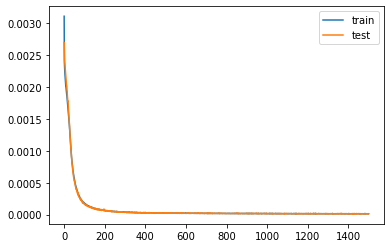

<Figure size 800x640 with 0 Axes>

In [24]:
# plot peoch loss graph
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.figure(figsize=(10,8),dpi=80)
plt.show()

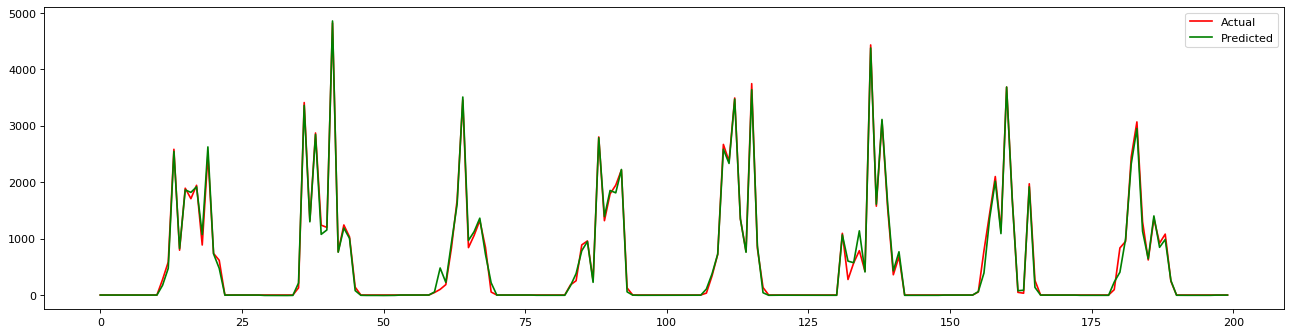

In [27]:
# Load Model
# file_path = "Liquor_ckpt_V0_L1_17_Dro1_0_De1_1a.hdf5"
model1 = load_model(file_path)
predicted = model1.predict(test_x)

# Reconstruct original values
test_y1 = (y_test * (max_quantity-min_quantity)) + min_quantity
pred_Model_1 = (predicted * (max_quantity-min_quantity)) + min_quantity
plt.figure(figsize=(20,5),dpi=80)
plt.plot(test_y1[:200], 'r',label='Actual')
plt.plot(pred_Model_1[:200], 'g', label='Predicted')
plt.legend()
plt.show()

In [18]:
score = r2_score(test_y1, pred_Model_1)
print('r2 score for model 1 : ',score)

r2 score for model 1 :  0.9979031303179644
